In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:
historic_df = pd.read_csv(r'Base de Dados//Dados Históricos - Ibovespa.csv', parse_dates=['Data'], index_col='Data')
historic_df = historic_df.sort_index()

historic_df['Var%'] = historic_df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

historic_df['Vol.'] = historic_df['Vol.'].str.replace(',', '.')

historic_df['Vol.'] = historic_df['Vol.'].apply(
    lambda x: float(str(x)[:-1].replace(',', '.'))/1_000  if str(x)[-1] == 'K'
    else float(str(x)[:-1].replace(',', '.')) if str(x)[-1] == 'M'
    else float(str(x)[:-1].replace(',', '.')) * 1_000 if str(x)[-1] == 'B'
    else float(str(x).replace(',', '.'))/1_000_000 )

historic_df.rename(columns={'Vol.':'Vol (M)'}, inplace=True)

In [ ]:
historic_df.info()

In [ ]:
historic_df.describe()

In [ ]:
delta_date = historic_df['Último'].iloc[-1] - historic_df['Último'].iloc[0]
line_trend = delta_date/(len(historic_df)-1)

historic_df['Trend'] = (line_trend * range(len(historic_df))) + historic_df['Último'].iloc[0]

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

# Plot da média móvel da variação percentual no eixo primário
line1, = ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.plot(historic_df.index, historic_df['Var%'].rolling(window=30).mean(), color='blue', label='Variação %')
ax.set_xlabel('Data')
ax.set_ylabel('Variação da Bolsa (%)')
ax.tick_params(axis='y')

# Criação do segundo eixo Y (para o fechamento da bolsa)
ay = ax.twinx()
line2, = ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
ay.plot(historic_df.index, historic_df['Último'].rolling(window=30).mean(), color='red', label='Fechamento Valor')
line3, = ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(), 
                 color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.plot(historic_df.index, historic_df['Trend'].rolling(window=30).mean(),
         color='black', linewidth=1, linestyle='--', label='Trend Line')
ay.set_ylabel('Fechamento da Bolsa')
ay.tick_params(axis='y')

# Título e layout
lines = [line3, line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')

plt.title('Média Móvel 30 dias - Variação % e Fechamento')
fig.tight_layout()

# Exibir gráfico
plt.show()

In [ ]:

historic_df

In [ ]:
historic_var_df = historic_df[['Var%']]
X = historic_var_df[['Var%']].values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")


In [ ]:
# Define training and test sets
train_end = '2025-03-01'
df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]

### CRIANDO O NAIVE PREDICT

In [ ]:
naive_pred = pd.Series(index=historic_df.index, dtype='float64')
naive_pred.loc[df_train.index] = historic_df['Último'].shift(1).loc[df_train.index]
last_train_value = historic_df['Último'].loc[df_train.index[-1]]
naive_pred.loc[df_test.index] = last_train_value


# Evaluation
from sklearn.metrics import mean_squared_error

mse_naive = mean_squared_error(df_test['Último'][1:], naive_pred.loc[df_test.index][1:])
print(f'Naive Baseline MSE: {mse_naive}')

### CRIANDO XGBoost PREDICT

In [ ]:
historic_df['day'] = historic_df.index.day
historic_df['week_of_year'] = [dt.weekofyear for dt in historic_df.index]
historic_df['month'] = historic_df.index.month
historic_df['year'] = historic_df.index.year


# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plot_acf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação (ACF)")


n_lags = 40
for lag in range(1, n_lags + 1):
    historic_df[f'lag_{lag}'] = historic_df['Último'].shift(lag)


# Rolling statistics
historic_df[f'rolling_mean_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).mean().shift(1)
historic_df[f'rolling_std_{n_lags}'] = historic_df['Último'].rolling(window=n_lags).std().shift(1)

# Exponential Moving Averages (EMA)
historic_df[f'ema_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).mean().shift(1)
historic_df[f'ema_std_{n_lags}'] = historic_df['Último'].ewm(span=n_lags).std().shift(1)



from scipy.signal import periodogram
frequency, power = periodogram(historic_df['Último'].dropna(), fs=1)

freq = frequency[np.argmax(power)]
period = 1 / freq

print(f'Period: {period} days')

historic_df['fourier_sin'] = np.sin(2 * np.pi * freq * np.arange(len(historic_df)))
historic_df['fourier_cos'] = np.cos(2 * np.pi * freq * np.arange(len(historic_df)))


predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
    'fourier_sin',
    'fourier_cos',
    'Máxima',	
    'Mínima',	
    'Vol (M)',	
    'Var%'
]



In [ ]:
df_train = historic_df.loc[:train_end]
df_test = historic_df.loc[train_end:]


In [ ]:

# Define features and target
X_train = df_train[predictors]
y_train = df_train['Último']
X_test = df_test[predictors]
y_test = df_test['Último']

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=100)
xgb = XGBRegressor(objective='reg:squarederror')

# Train with cross-validation
xgb_models = []
mse = []
count = 0
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb.fit(X_tr, y_tr)
    val_pred = xgb.predict(X_val)
    # print(f'{count} Validation MSE: {mean_squared_error(y_val, val_pred)}')
    count = count + 1 
    mse.append(mean_squared_error(y_val, val_pred))
    xgb_models.append(xgb)

best_model_idx = mse.index(min(mse))
print(f'Best Model Idx: {best_model_idx}')

xgb = xgb_models[best_model_idx]

# Predict on the test set
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')

In [ ]:
xgb_pred_series = pd.Series(xgb_pred, index=df_test.index, name='pred')
xgb_pred_df = xgb_pred_series.astype('float64')

xgb_pred_df

### CRIANDO ARIMA PREDICT

In [ ]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação (ACF)")
plt.subplot(122)
plot_pacf(historic_df["Último"].dropna(), ax=plt.gca(), lags=40)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

In [ ]:
p = 3 
d = 1
q = 40

model_arima = ARIMA(df_train["Último"], order=(p, d, q))
resultado_arima = model_arima.fit()

arima_pred = resultado_arima.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)

arima_mse = mean_squared_error(y_test, arima_pred)
print(f'ARIMA MSE: {arima_mse}')

arima_pred.index = df_test.index 
arima_pred_series = pd.Series(arima_pred, index=df_test.index, name='pred')
arima_pred_df = arima_pred_series.astype('float64')

arima_pred_df


### CRIANDO O PROPHET PREDICT

In [ ]:
data = df_train[['Último']].copy()
data['ds'] = data.index

data.rename(columns={'Último': 'y'}, inplace=True)

delta_days = (df_test.index[-1]-df_train.index[-1]).days


# Ajustando o modelo Prophet com o seu DataFrame
model = Prophet()
model.fit(data)

# Gerando o futuro para o número de dias calculado
future = model.make_future_dataframe(periods=delta_days)

# Fazendo a previsão
prophet_pred = model.predict(future)


fig = model.plot(prophet_pred)

# Exibindo o gráfico
plt.title('Previsão usando o Prophet')
plt.show()

prophet_pred.set_index('ds', inplace=True)
prophet_pred_series = pd.Series(prophet_pred['yhat'], index=df_test.index, name='pred')
prophet_pred_df = prophet_pred_series.astype('float64')


### CRIANDO O RANDOM FOREST PREDICT

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Remover nulos após defasagens
df_train_rf = df_train.dropna()
X_train_rf = df_train_rf[predictors]
y_train_rf = df_train_rf['Último']

df_test_rf = df_test.dropna()
X_test_rf = df_test_rf[predictors]
y_test_rf = df_test_rf['Último'].loc[X_test_rf.index]

# Modelo
rf_model = RandomForestRegressor(n_estimators=100)



rf_model.fit(X_train_rf, y_train_rf)
rf_pred = rf_model.predict(X_test_rf)


rf_pred_series = pd.Series(rf_pred, index=df_test.index, name='pred')
rf_pred_df = rf_pred_series.astype('float64')

### TESTE DE CONFIABILIDADE

In [ ]:

mae_naive = mean_absolute_error(df_test['Último'], naive_pred[train_end:])
rmse_naive = mean_squared_error(df_test['Último'], naive_pred[train_end:])
mape_naive = 100 * mean_absolute_percentage_error(df_test['Último'], naive_pred[train_end:])

mae_xgb = mean_absolute_error(df_test['Último'], xgb_pred)
rmse_xgb = mean_squared_error(df_test['Último'], xgb_pred)
mape_xgb = 100 * mean_absolute_percentage_error(df_test['Último'], xgb_pred)

mae_arima = mean_absolute_error(df_test['Último'], arima_pred)
rmse_arima = mean_squared_error(df_test['Último'], arima_pred)
mape_arima = 100 * mean_absolute_percentage_error(df_test['Último'], arima_pred)

mae_prophet = mean_absolute_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
rmse_prophet = mean_squared_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])
mape_prophet = 100 * mean_absolute_percentage_error(df_test['Último'], prophet_pred.loc[df_test.index]['yhat'])

mae_rf = mean_absolute_error(df_test['Último'], rf_pred)
rmse_rf = mean_squared_error(df_test['Último'], rf_pred)
mape_rf = 100 * mean_absolute_percentage_error(df_test['Último'], rf_pred)


resultados = pd.DataFrame(
    {
        "Modelo": ["XGBoost", "Naive", "Arima", "Prophet", "Random Forest"],
        "MAE": [mae_xgb, mae_naive, mae_arima, mae_prophet, mae_rf],
        "RMSE": [rmse_xgb, rmse_naive, rmse_arima, rmse_prophet, rmse_rf],
        "MAPE (%)": [mape_xgb, mape_naive, mape_arima, mape_prophet, mape_rf],
        "Accuracy (%)": [
            100 - mape for mape in [mape_xgb, mape_naive, mape_arima, mape_prophet, mape_rf]
        ],
    }
).sort_values("MAPE (%)").reset_index(drop=True)

resultados


In [ ]:
historic_filter = historic_df.tail(20)
delta_date = historic_filter['Último'].iloc[-1] - historic_filter['Último'].iloc[0]
line_trend = delta_date/(len(historic_filter)-1)
historic_filter['Trend'] = (line_trend * range(len(historic_filter))) + historic_filter['Último'].iloc[0]

naive_filter = naive_pred.tail(20)


fig, ax = plt.subplots(figsize=(12,6))

# Fechamento act
line2, = ax.plot(historic_filter.index, historic_filter['Último'], color='red', label='Fechamento Act')

# Linha de tendência
line3, = ax.plot(historic_filter.index, historic_filter['Trend'], 
                 color='black', label='Trend Line')

# Previsão Naive 
line4, = ax.plot(df_test.index, naive_filter.loc[df_test.index], color='green', linestyle=':', linewidth=1.5, label='Naive Pred')

# Previsão XGBoost
line5, = ax.plot(df_test.index, xgb_pred_df.loc[df_test.index], color='blue', linestyle=':', linewidth=1.5, label='XGB Pred')

# Previsão Arima
line6, = ax.plot(df_test.index, arima_pred_df.loc[df_test.index], color='orange', linestyle=':', linewidth=1.5, label='Arima Pred')

# Previsão Prophet
line7, = ax.plot(df_test.index, prophet_pred_df.loc[df_test.index], color='black', linestyle=':', linewidth=1.5, label='Prophet Pred')

# Previsão Prophet
line8, = ax.plot(df_test.index, rf_pred_df.loc[df_test.index], color='gray', linestyle=':', linewidth=1.5, label='Random Forest')

ax.set_ylabel('Fechamento da Bolsa')
ax.tick_params(axis='y')

# Título e legenda
lines = [line2, line3, line4, line5, line6, line7, line8]  # A lista de objetos de linha
# Usando get_label() corretamente
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='upper left')
ax.set_ylim(top=140)


plt.title('60 dias - Act x Trend x Naive x XGBoost x Prophet x Random Forest')
fig.tight_layout()

plt.show()

In [ ]:
predictions = np.array([tree.predict(X_test_rf) for tree in rf_model.estimators_])

# Média das previsões (previsão final)
rf_pred = predictions.mean(axis=0)
std_dev = predictions.std(axis=0)
lower_bound = rf_pred - 1.96 * std_dev  # Intervalo inferior
upper_bound = rf_pred + 1.96 * std_dev  # Intervalo superior

In [47]:
rf_intervalo = pd.DataFrame({
    'pred': rf_pred,
    'lower': lower_bound,
    'upper': upper_bound
}, index=df_test.index)


rf_intervalo

,pred,lower,upper
Data,,,
2025-03-05,123.18482,121.468416,124.901224
2025-03-06,123.35709,121.473152,125.241028
2025-03-07,124.90642,121.991559,127.821281
2025-03-10,124.06680,122.533960,125.599640
2025-03-11,123.55557,121.901160,125.209980
2025-03-12,123.29281,121.563278,125.022342
2025-03-13,125.42975,123.561195,127.298305
2025-03-14,128.03564,126.275232,129.796048
2025-03-17,130.26195,128.769074,131.754826


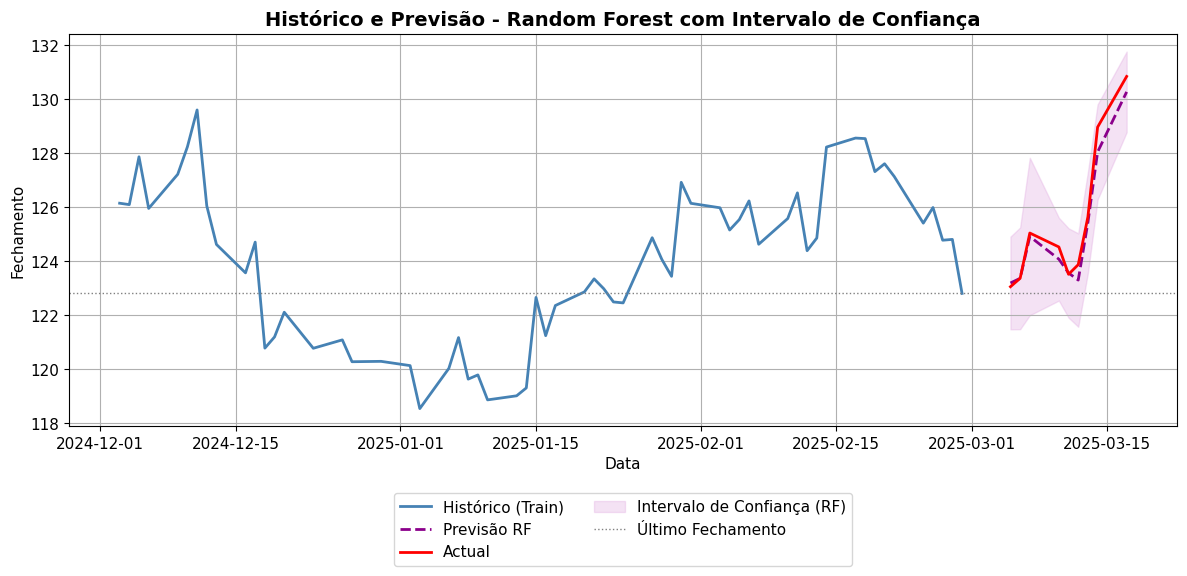

In [56]:
import matplotlib.pyplot as plt

df_train_final = df_train.tail(60)

fig, ax = plt.subplots(figsize=(12,6))

# Plot histórico
ax.plot(df_train_final.index, df_train_final['Último'], label='Histórico (Train)', color='steelblue', linewidth=2)

# Plot Previsão Random Forest
ax.plot(rf_intervalo.index, rf_intervalo['pred'], label='Previsão RF', color='darkmagenta', linestyle='--', linewidth=2)
ax.plot(df_test.index, df_test['Último'], label='Actual', color='red', linestyle='-', linewidth=2)

# Plot faixa de intervalo de confiança (shaded area)
ax.fill_between(rf_intervalo.index, 
                rf_intervalo['lower'], 
                rf_intervalo['upper'], 
                color='plum', alpha=0.3, label='Intervalo de Confiança (RF)')

# Linha de referência (último valor do histórico)
ax.axhline(y=df_train_final['Último'].iloc[-1], color='gray', linestyle=':', linewidth=1, label='Último Fechamento')

# Eixos
ax.set_title('Histórico e Previsão - Random Forest com Intervalo de Confiança', fontsize=14, fontweight='bold')
ax.set_ylabel('Fechamento')
ax.set_xlabel('Data')

# Estética
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=True)
ax.grid(True)
plt.tight_layout()
plt.show()
